In [157]:
import torch
import torch.nn as nn
import timm  # For pretrained ViTs

class VisionTransformerDepth(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224", output_size=(224, 224)):
        super(VisionTransformerDepth, self).__init__()
        self.vit = timm.create_model(model_name, pretrained=True)
        self.vit.head = nn.Identity()  # Remove classification head

        # Decoder for depth prediction
        self.decoder = nn.Sequential(
            nn.Conv2d(768, 256, kernel_size=3, stride=1, padding=1),  # Adjust for ViT output channels
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=1),  # Output single channel for depth
            nn.Upsample(size=output_size, mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        # Forward pass through Vision Transformer
        features = self.vit(x)

        # Check if the output has 2 or 3 dimensions
        if features.ndimension() == 2:
            # If only 2D (B, D), we need to expand it to match the 3D shape (B, N, D)
            B, D = features.size()  # B = batch size, D = embedding dimension
            N = 196  # Assuming a 16x16 patch grid for 224x224 image
            features = features.unsqueeze(1).expand(B, N, D)

        # Now, features should have the shape (B, N, D)
        B, N, D = features.size()  # B = batch size, N = number of patches (196 for 224x224 image with 16x16 patches)

        # Calculate the spatial dimensions based on patch size
        H, W = 14, 14  # 224 / 16 = 14 (This is the spatial resolution after patch embedding)


        features = features.reshape(B, D, H, W)


        # Pass through the decoder to get the depth map
        depth_map = self.decoder(features)
        return depth_map



In [158]:
from torchvision import transforms
from PIL import Image

# Step 2: Dataset Loader
class DepthEstimationDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, depth_paths, transform=None):
        self.image_paths = image_paths
        self.depth_paths = depth_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = self._load_image(self.image_paths[idx])
        depth = self._load_depth(self.depth_paths[idx])

        if self.transform:
            img = self.transform(img)
            depth = self.transform(depth)  # Apply the same transform to depth map

        return img, depth

    def _load_image(self, path):
        # Load the image using PIL
        return Image.open(path).convert('RGB')

    def _load_depth(self, path):
        # Load the depth map (grayscale)
        return Image.open(path).convert('L')


<ipython-input-159-6436932ba6a8>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("vit_depth_model.pth", map_location='cpu'), strict=False)


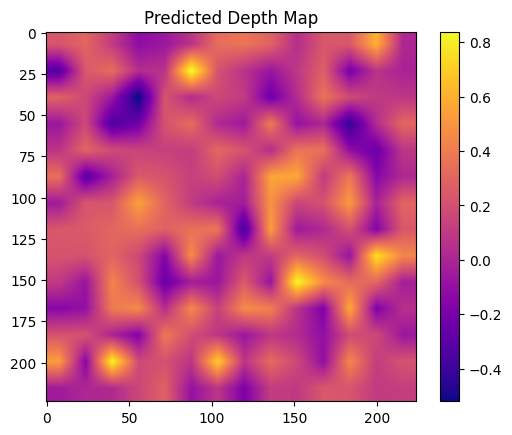

In [159]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

# Step 1: Load the model (make sure it's in evaluation mode)
model = VisionTransformerDepth()  # Initialize model
model.load_state_dict(torch.load("vit_depth_model.pth", map_location='cpu'), strict=False)
model.eval()

# Step 2: Load the image you want to make predictions on
img_path = "/content/test_image.jpg"  # Ensure this is correct
img = Image.open(img_path).convert('RGB')


# Step 3: Apply the same transformations used during training (resize and tensor conversion)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Step 4: Make a prediction
with torch.no_grad():  # Turn off gradient computation for inference
    depth_map = model(img_tensor)

# Step 5: Post-process the predicted depth map (optional)
depth_map = depth_map.squeeze().cpu().numpy()  # Remove batch dimension and convert to NumPy

# Step 6: Display the result
plt.imshow(depth_map, cmap='plasma')
plt.colorbar()
plt.title("Predicted Depth Map")
plt.show()


In [160]:
torch.save(model.state_dict(), "vit_depth_model.pth")
